In [1]:
import numpy as np
from numpy.linalg import inv
from astropy.io import fits
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Theta from 0 to 180 degrees in increments of 5 degrees (for the first QWP). The second QWP rotates at 5 times this rate (25 degree increments)
theta = np.linspace(0, np.pi, 37)
longtheta = np.linspace(0, np.pi, 46)
degtheta = theta*180/np.pi

In [3]:
# Mueller matrix for a linear polarizer, with angle a between transmission axis and horizontal (radians)
def linear_polarizer(a):
    M01 = np.cos(2*a)
    M02 = np.sin(2*a)
    M10 = np.cos(2*a)
    M11 = np.cos(2*a)**2
    M12 = np.cos(2*a)*np.sin(2*a)
    M20 = np.sin(2*a)
    M21 = np.cos(2*a)*np.sin(2*a)
    M22 = np.sin(2*a)**2

    return 0.5*np.array([[1, M01, M02, 0], 
                         [M10, M11, M12, 0], 
                         [M20, M21, M22, 0], 
                         [0, 0, 0, 0]])

In [4]:
# Mueller matrix for a linear retarder (waveplate). Angle of fast axis a, retardance r in radians
def linear_retarder(a, r):
    M11 = np.cos(2*a)**2 + np.cos(r)*np.sin(2*a)**2
    M12 = np.cos(2*a)*np.sin(2*a)*(1-np.cos(r))
    M13 = -np.sin(2*a)*np.sin(r)
    M21 = M12
    M22 = np.sin(2*a)**2 + np.cos(2*a)**2*np.cos(r)
    M23 = np.cos(2*a)*np.sin(r)
    M31 = -M13
    M32 = -M23
    M33 = np.cos(r)

    return np.array([[1, 0, 0, 0], 
                     [0, M11, M12, M13], 
                     [0, M21, M22, M23], 
                     [0, M31, M32, M33]])

In [5]:
# Sorting function for extracting filenames based on last number in the filename (the angle of rotation)
def extract_number(filename):
    match = re.findall(r'\d+(?:\.\d+)?', filename)
    if match:
        return float(match[-1])

In [6]:
# Function to subtract dark frames from raw frames. The new reduced images are saved to a different folder
def dark_subtraction(image_file, dark_file, old_directory, new_directory):
    # Open the dark image and extract pixel values
    fits.open(dark_file)
    dark = fits.getdata(dark_file)
    dark_median = np.median(dark, axis=0)

    # Search through the desired raw data folder
    for filename in os.listdir(old_directory):
        if filename.startswith(image_file):                                # Call specific files starting with the desired name
            with fits.open(os.path.join(old_directory, filename)) as hdul:
                img_data = hdul[0].data
                img_median = np.median(img_data, axis=0)
                reduced_data = img_median - dark_median

            # Save the newly reduced image to a reduced data folder
            new_filename = f"Reduced_{filename}"
            new_filepath = os.path.join(new_directory, new_filename)
            fits.writeto(new_filepath, reduced_data, overwrite=True)

In [7]:
# Get intensity values from each spot in the reduced images. reduced_filename should just be the start of the name (leave out the last number, the angle). 
def extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff=5000):
    I_left = np.array([])
    I_right = np.array([])
    bad_indices = np.array([])

    for filename in sorted(os.listdir(reduced_folder), key = extract_number):
        if filename.startswith(reduced_filename):
            with fits.open(os.path.join(reduced_folder, filename)) as hdul:
                reduced_img_data = hdul[0].data
                ys, xs, = np.indices(reduced_img_data.shape)
                lradius = np.sqrt((ys-lcenter[0])**2+(xs-lcenter[1])**2)
                rradius = np.sqrt((ys-rcenter[0])**2+(xs-rcenter[1])**2)

                lbackground_mask = (lradius > 20) & (lradius < 26)
                rbackground_mask = (rradius > 20) & (rradius < 26)   # Index the background around each spot, take the median value

                background_lmedian = np.median(reduced_img_data[lbackground_mask])
                background_rmedian = np.median(reduced_img_data[rbackground_mask])

                lflux = np.sum(reduced_img_data[lradius < maxradius] - background_lmedian)   # Now take the flux with the background mask subtracted
                rflux = np.sum(reduced_img_data[rradius < maxradius] - background_rmedian)
                I_left = np.append(I_left, lflux)
                I_right = np.append(I_right, rflux)

                if lflux+rflux < cutoff:
                    print("Warning: low flux detected, check the image " + filename + ", index: " + str(sorted(os.listdir(reduced_folder), key = extract_number).index(filename)))
                    bad_indices = np.append(bad_indices, sorted(os.listdir(reduced_folder), key = extract_number).index(filename))
                else:
                    continue 

    return I_left, I_right, bad_indices

In [8]:
# Gives the condition number of eventual Mueller matrix (made by Jaren)
def condition_number(matrix):
    minv = np.linalg.pinv(matrix)

    # Compute maximum norm
    norm = np.linalg.norm(matrix, ord=np.inf)
    ninv = np.linalg.norm(minv, ord=np.inf)

    return norm*ninv

In [9]:
# Function to compute the Mueller matrix of a sample based on DRRP intensity measurements. Big thanks to Jaren for this part!
def original_full_mueller_polarimetry(thetas, I_meas=1, LPA_angle=0, return_condition_number=False, M_in=None):
    nmeas = len(thetas)
    Wmat = np.zeros([nmeas, 16])
    Pmat = np.zeros([nmeas])
    th = thetas

    for i in range(nmeas):
        # Mueller Matrix of generator (linear polarizer and a quarter wave plate)
        Mg = linear_retarder(th[i], np.pi/2) @ linear_polarizer(0)

        # Mueller Matrix of analyzer (one channel of the Wollaston prism is treated as a linear polarizer. The right spot is horizontal (0) and the left spot is vertical(pi/2))
        Ma = linear_polarizer(LPA_angle) @ linear_retarder(th[i]*5, np.pi/2)

        # Data reduction matrix. Taking the 0 index ensures that intensity is the output
        Wmat[i,:] = np.kron(Ma[0,:], Mg[:,0])

        # M_in is some example Mueller matrix. Providing this input will test theoretical Mueller matrix. Otherwise, the raw data is used
        if M_in is not None:
            Pmat[i] = (Ma[0,:] @ M_in @ Mg[:,0]) * I_meas
        else:
            Pmat[i] = I_meas[i]

    # Compute Mueller matrix using Moore-Penrose pseudo invervse
    M = np.linalg.pinv(Wmat) @ Pmat
    M = np.reshape(M,[4,4])

    if return_condition_number == True:
        return M, condition_number(Wmat)
    else:
        return M

In [10]:
# Function to compute the Mueller matrix of a sample based on DRRP intensity measurements and calibration parameters
def calibrated_full_mueller_polarimetry(thetas, a1, a2, w1, w2, r1, r2, I_meas=1, LPA_angle=0, return_condition_number=False, M_in=None):
    nmeas = len(thetas)
    Wmat = np.zeros([nmeas, 16])
    Pmat = np.zeros([nmeas])
    th = thetas

    for i in range(nmeas):
        # Mueller Matrix of generator (linear polarizer and a quarter wave plate)
        Mg = linear_retarder(th[i]+w1, np.pi/2+r1) @ linear_polarizer(0+a1)

        # Mueller Matrix of analyzer (one channel of the Wollaston prism is treated as a linear polarizer. The right spot is horizontal (0) and the left spot is vertical(pi/2))
        Ma = linear_polarizer(LPA_angle+a2) @ linear_retarder(th[i]*5+w2, np.pi/2+r2)

        # Data reduction matrix. Taking the 0 index ensures that intensity is the output
        Wmat[i,:] = np.kron(Ma[0,:], Mg[:,0])

        # M_in is some example Mueller matrix. Providing this input will test theoretical Mueller matrix. Otherwise, the raw data is used
        if M_in is not None:
            Pmat[i] = (Ma[0,:] @ M_in @ Mg[:,0]) * I_meas
        else:
            Pmat[i] = I_meas[i]

    # Compute Mueller matrix using Moore-Penrose pseudo invervse
    M = np.linalg.pinv(Wmat) @ Pmat
    M = np.reshape(M,[4,4])

    if return_condition_number == True:
        return M, condition_number(Wmat)
    else:
        return M

In [11]:
# Define the identity matrix and other matrices which are useful for the Mueller calculus
M_identity = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
A = np.array([1, 0, 0, 0])
B = np.array([[1], [0], [0], [0]])

In [12]:
# This is the full Mueller matrix equation for our setup. The output is a list, useful for curve fitting. Variables with 1 refer to the generator, 2 refers to analyzer. 
def calibration_function(t, a1, a2, w1, w2, r1, r2):
    prediction = [None]*len(t)
    for i in range(len(t)):
        prediction[i] = float(A @ linear_polarizer(a2) @ linear_retarder(5*t[i]+w2, np.pi/2+r2) @ M_identity @ linear_retarder(t[i]+w1, np.pi/2+r1) @ linear_polarizer(a1) @ B)
    return prediction

In [13]:
# Calibration function designed for data from the left spot, which is the vertial alignment. This changes the angle of the analyzing LP
def vertical_calibration_function(t, a1, a2, w1, w2, r1, r2):
    prediction = [None]*len(t)
    for i in range(len(t)):
        prediction[i] = float(A @ linear_polarizer(a2+np.pi/2) @ linear_retarder(5*t[i]+w2, np.pi/2+r2) @ M_identity @ linear_retarder(t[i]+w1, np.pi/2+r1) @ linear_polarizer(a1) @ B)
    return prediction

In [14]:
# Basically the same as above, but with an optional input matrix to simulate data
def output_simulation_function(t, a1, a2, w1, w2, r1, r2, LPA_angle=0, M_in=None):
    if M_in is None:
        M = M_identity
    else:
        M = M_in

    prediction = [None]*len(t)
    for i in range(len(t)):
        prediction[i] = float(A @ linear_polarizer(LPA_angle+a2) @ linear_retarder(5*t[i]+w2, np.pi/2+r2) @ M @ linear_retarder(t[i]+w1, np.pi/2+r1) @ linear_polarizer(a1) @ B)
    return prediction

In [15]:
# After testing, each of the above functions works individually. Now combine them into one function to rule them all
# Finds the mueller matrix derived from each channel separately, then averages the two retardances found this way
# First three inputs must come from the calibration data, last three inputs correspond to the HWP sample
def ultimate_polarimetry(cal_angles, cal_left_intensity, cal_right_intensity, sample_angles, sample_left_intensity, sample_right_intensity):
    initial_guess = [0, 0, 0, 0, 0, 0]
    parameter_bounds = ([-np.pi, -np.pi, -np.pi, -np.pi, -np.pi/2, -np.pi/2], [np.pi, np.pi, np.pi, np.pi, np.pi/2, np.pi/2])

    # Find parameters from calibration of the left spot
    lnormalized_intensity = cal_left_intensity/(2*max(cal_left_intensity))
    lpopt, lpcov = curve_fit(vertical_calibration_function, cal_angles, lnormalized_intensity, p0=initial_guess, bounds=parameter_bounds)
    print(lpopt, "Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer")
    #print(np.sqrt(np.diag(lpcov)))

    # Find parameters from calibration of the right spot
    rnormalized_intensity = cal_right_intensity/(2*max(cal_right_intensity))
    rpopt, rpcov = curve_fit(calibration_function, cal_angles, rnormalized_intensity, p0=initial_guess, bounds=parameter_bounds)
    print(rpopt, "Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer")
    #print(np.sqrt(np.diag(rpcov)))

    # Optional print the calibration matrices (should be close to identity) to see how well the parameters compensate
    MlCal = calibrated_full_mueller_polarimetry(cal_angles, lpopt[0], lpopt[1], lpopt[2], lpopt[3], lpopt[4], lpopt[5], cal_left_intensity, LPA_angle=np.pi/2)
    print(MlCal/MlCal.max(), ' Left calibration')
    MrCal = calibrated_full_mueller_polarimetry(cal_angles, rpopt[0], rpopt[1], rpopt[2], rpopt[3], rpopt[4], rpopt[5], cal_right_intensity)
    print(MrCal/MrCal.max(), ' Right calibration')

    # Use the parameters found above from curve fitting to construct the actual Mueller matrix of the sample
    Ml = calibrated_full_mueller_polarimetry(sample_angles, lpopt[0], lpopt[1], lpopt[2], lpopt[3], lpopt[4], lpopt[5], sample_left_intensity, LPA_angle=np.pi/2)
    Ml = Ml/Ml.max()

    Mr = calibrated_full_mueller_polarimetry(sample_angles, rpopt[0], rpopt[1], rpopt[2], rpopt[3], rpopt[4], rpopt[5], sample_right_intensity)
    Mr = Mr/Mr.max()

    np.set_printoptions(suppress=True)

    # Extract retardance from the last entry of the mueller matrix, which should just be cos(phi)
    lretardance = np.arccos(Ml[3,3])/(2*np.pi)
    rretardance = np.arccos(Mr[3,3])/(2*np.pi)
    print(lretardance, ' This is the retardance found from the left spot')
    print(rretardance, ' This is the retardance found from the right spot')

    avg_retardance = (lretardance+rretardance)/2

    return Ml, Mr, avg_retardance

Lets start by analyzing the data from 1400 nm, taken with 300 fps and 3.3 tint. 4 degree angle increments

In [116]:
# First subtract the dark and save new images to the reduced folder
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Raw\\Cal_1400_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1400_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [120]:
reduced_filename = 'Reduced_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1400_Reduced\\"
lcenter = [256, 251]
rcenter = [256, 328]
maxradius = 9
cutoff = 10000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1400 = extracted_data[0]
Cal_Ir_1400 = extracted_data[1]

In [121]:
Cal_Il_1400 = np.delete(Cal_Il_1400, [37, 45])
Cal_Ir_1400 = np.delete(Cal_Ir_1400, [37, 45])
Cal_theta1400 = np.delete(longtheta, [37, 45])

In [122]:
uncompensated_calibration = original_full_mueller_polarimetry(Cal_theta1400, Cal_Ir_1400)
print(uncompensated_calibration/uncompensated_calibration.max())

[[ 1.         -0.20075618  0.28464035 -0.00218511]
 [-0.07749849  0.88699688  0.11571733 -0.02000679]
 [ 0.31584713 -0.17842825  0.79832689 -0.04831681]
 [-0.01774643  0.0150631   0.01651488  0.77151842]]


In [115]:
# plt.xlabel('Angle (degrees)')
# plt.ylabel('Normalized Intensity')

# plt.plot(Cal_theta1400*180/np.pi, Cal_Ir_1400/(2*max(Cal_Ir_1400)), marker='o', color='blue', label='1400nm Calibration')

# plt.legend()

In [123]:
# Now bring in the actual sample data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_1400_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1400_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [128]:
reduced_filename = 'Reduced_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1400_Reduced\\"
lcenter = [256, 251]
rcenter = [255, 327]
maxradius = 9
cutoff = 12000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1400 = extracted_data[0]
Ir_1400 = extracted_data[1]

In [129]:
Il_1400 = np.delete(Il_1400, [33])
Ir_1400 = np.delete(Ir_1400, [33])
theta1400 = np.delete(longtheta, [33])

In [131]:
ultimate_polarimetry(Cal_theta1400, Cal_Il_1400, Cal_Ir_1400, theta1400, Il_1400, Ir_1400)

[ 0.01802094  0.1653776  -0.14326586 -0.03399563  0.03838767 -0.00312243] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.02460568  0.1661886  -0.13918473 -0.03309941  0.01198401 -0.02420674] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 0.99884733 -0.01299947  0.00723767  0.00091085]
 [ 0.00854703  0.97922187  0.0019105   0.00365348]
 [ 0.01385125 -0.02570059  1.         -0.00333318]
 [-0.00731015  0.00313016  0.01510957  0.99365258]]  Left calibration
[[ 0.95940558 -0.03343255  0.00360317  0.00398272]
 [-0.03355191  1.         -0.00890669 -0.0114963 ]
 [-0.00464878  0.00033587  0.97510938  0.00373927]
 [ 0.00562333 -0.01248029 -0.0064632   0.94200498]]  Right calibration
nan  This is the retardance found from the left spot
0.48024522465689923  This is the retardance found from the right spot


C:\Users\EPL User\AppData\Local\Temp\ipykernel_16676\1943479580.py:36: RuntimeWarning: invalid value encountered in arccos
  lretardance = np.arccos(Ml[3,3])/(2*np.pi)


(array([[ 1.        ,  0.03430761,  0.00180127,  0.00330111],
        [-0.01849026,  0.67584751, -0.78698029, -0.0739076 ],
        [-0.01756761, -0.77388049, -0.61063709,  0.02519464],
        [-0.00006205, -0.07228851,  0.05605723, -1.0131043 ]]),
 array([[ 1.        ,  0.01152158,  0.02618106,  0.00265406],
        [-0.00397319,  0.60947631, -0.80280377, -0.07341985],
        [ 0.04358228, -0.86439886, -0.63362275,  0.03044923],
        [ 0.0012894 , -0.07297245,  0.0412014 , -0.99230664]]),
 nan)

Try again with the 1500 nm data, 300 fps, 3 tint

In [55]:
# First subtract the dark and save new images to the reduced folder
raw_image = 'DRRP_Cal_1500nm_300_3_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Raw\\Cal_1500_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1500_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [19]:
reduced_filename = 'Reduced_DRRP_Cal_1500nm_300_3_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1500_Reduced\\"
lcenter = [242, 246]
rcenter = [242, 321]
maxradius = 10
cutoff = 15000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1500 = extracted_data[0]
print(Cal_Il_1500)
Cal_Ir_1500 = extracted_data[1]
print(Cal_Ir_1500)
print('Bad indices: ' + str(extracted_data[2]))

[  501.5   7379.5  11572.    5073.5   -170.5   2666.    5263.    7498.5
 15304.   21140.5  16780.5   8098.    2564.5   -164.5   3638.5  13673.
 16478.    6604.     548.5   6912.   11899.    5170.    2743.5   2664.5
  4024.5   7396.   15083.   20996.   16830.5   8386.75  3786.5    -42.5
  6602.75 13733.   16571.    6493.5    422.  ]
[17598.5  11805.    7872.   13789.5  18174.5  15861.5  13617.   11512.
  5080.5     21.5   3693.5  11176.5  16066.   18219.   14843.    6338.5
  3927.5  12447.5  17707.5   1069.75  7929.   13753.5   2179.75 15916.
  2850.75 11558.5   4965.5     59.5   3789.5  -3741.   -5006.   18128.5
  -876.5   6184.5   3771.   12319.5  17652.5 ]
Bad indices: [19. 22. 24. 29. 30. 32.]


In [20]:
Cal_Il_1500 = np.delete(Cal_Il_1500, [19, 22, 24, 29, 30, 32])
Cal_Ir_1500 = np.delete(Cal_Ir_1500, [19, 22, 24, 29, 30, 32])
Cal_theta1500 = np.delete(theta, [19, 22, 24, 29, 30, 32])

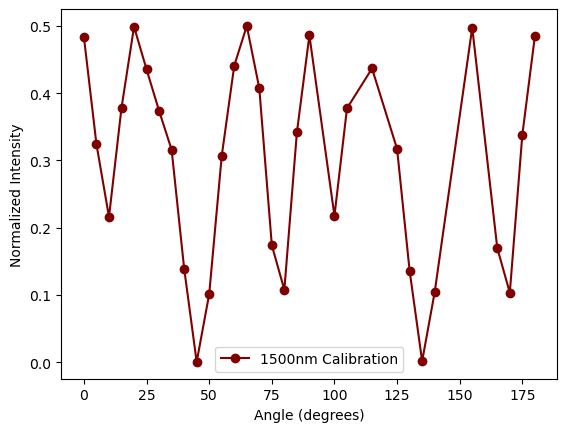

In [61]:
plt.xlabel('Angle (degrees)')
plt.ylabel('Normalized Intensity')

plt.plot(Cal_theta1500*180/np.pi, Cal_Ir_1500/(2*max(Cal_Ir_1500)), marker='o', color='maroon', label='1500nm Calibration')

plt.legend()

In [64]:
# Now bring in the actual sample data
raw_image = 'DRRP_Uncoated_1500nm_300_3_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_1500_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1500_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [16]:
reduced_filename = 'Reduced_DRRP_Uncoated_1500nm_300_3_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1500_Reduced\\"
lcenter = [242, 245]
rcenter = [242, 322]
maxradius = 9
cutoff = 10000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1500 = extracted_data[0]
print(Il_1500)
Ir_1500 = extracted_data[1]
print(Ir_1500)
print('Bad indices: ' + str(extracted_data[2]))

[ 1469.  11318.5  9804.5    61.   9271.5  8318.5  4525.5 11567.  13921.5
  5936.5  6456.  14480.  16416.5 11561.   6740.5  6758.   6295.5  1676.5
  2890.   7455.5  3435.    795.5  8708.  15931.5 14987.5 -1109.5   846.
  4556.   7938.   4392.   7495.  10873.   3095.   2217.   8279.5  3020.5
  1406.5]
[14195.    5859.    6897.5  -7041.75  7378.    8262.   11607.    5509.5
  3595.   10311.    9853.    3006.    1270.5   5452.5   9558.    9455.5
 10070.   14077.5  12947.    8961.5  12512.   14669.5   8004.5   1690.
  2571.5   4003.5  14743.5  11445.5   8513.   11719.5   8974.    6088.
 12782.5  13512.5   8057.   12846.5  14121.5 ]
Bad indices: [ 3. 25.]


In [17]:
Il_1500 = np.delete(Il_1500, [3, 25])
Ir_1500 = np.delete(Ir_1500, [3, 25])
theta1500 = np.delete(theta, [3, 25])

In [31]:
ultimate_polarimetry(Cal_theta1500, Cal_Il_1500, Cal_Ir_1500, theta1500, Il_1500, Ir_1500)

[ 0.01709696  0.02533394 -0.08381088  0.07940705  0.02417637  0.0138232 ] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.02212073  0.02343174 -0.07999217  0.08031278  0.04062551  0.03165996] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 0.96429936  0.00071172  0.00119627  0.00017991]
 [ 0.00096998  0.9749781  -0.00004583 -0.00071647]
 [-0.00191668  0.00144982  1.         -0.0051813 ]
 [ 0.00610824 -0.01305199  0.0003901   0.96535973]]  Left calibration
[[ 0.9975607  -0.00080206  0.01327481  0.0034383 ]
 [-0.00212793  0.99527084 -0.00936503 -0.00200887]
 [-0.00807852  0.01371927  0.9809434   0.00884469]
 [ 0.00290749 -0.00852333  0.00071313  1.        ]]  Right calibration
0.3196534949496274  This is the retardance found from the left spot
0.31990017047674374  This is the retardance found from the right spot


(array([[ 1.        ,  0.00389432,  0.00155661, -0.00169829],
        [-0.00796518,  0.81764586, -0.47216804, -0.33085486],
        [ 0.00780058, -0.51988438, -0.21918182, -0.74532642],
        [ 0.00294996,  0.26287482,  0.76905377, -0.42380833]]),
 array([[ 1.        ,  0.00851145, -0.003783  , -0.00357624],
        [ 0.01387631,  0.79592791, -0.45336219, -0.33205357],
        [ 0.00768369, -0.51366579, -0.20716117, -0.74576441],
        [ 0.00244981,  0.25419841,  0.77118957, -0.42521166]]),
 0.3197768327131856)

In [22]:
M1500 = calibrated_full_mueller_polarimetry(theta1500, 0.02212073, 0.02343174, -0.07999217, 0.08031278, 0.04062551, 0.03165996, Ir_1500)
print(M1500/M1500.max())

[[ 1.          0.00851144 -0.003783   -0.00357624]
 [ 0.0138763   0.79592793 -0.45336217 -0.33205357]
 [ 0.00768369 -0.51366579 -0.20716119 -0.74576442]
 [ 0.00244982  0.2541984   0.77118958 -0.42521166]]


In [24]:
np.arccos(-0.4252)/(2*np.pi)

0.31989812059845585

The above data doesn't look like the right retardance, so try keeping the same conditions and same calibration but retake the 1500 nm data

In [32]:
# Now bring in the actual sample data
raw_image = 'DRRP_Uncoated_1500nm_Retake'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_1500_Retake_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1500_Retake_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [38]:
reduced_filename = 'Reduced_DRRP_Uncoated_1500nm_Retake'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1500_Retake_Reduced\\"
lcenter = [258, 250]
rcenter = [257, 326]
maxradius = 9
cutoff = 10000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Retake_Il_1500 = extracted_data[0]
print(Retake_Il_1500)
Retake_Ir_1500 = extracted_data[1]
print(Retake_Ir_1500)
print('Bad indices: ' + str(extracted_data[2]))

[ 1312.5   9679.    8488.5   4004.5   7980.5    396.   -3833.75 10010.5
 -5938.    5184.    5522.   12378.5  14141.   10090.    5814.5   5997.5
  5573.    1421.5   2571.    6337.    -164.5    692.5   7466.5  13849.
 12823.    6177.     792.5    -45.    6781.5   3774.    6489.5   9390.
  2780.5   1901.    7405.5   2709.5   1347.5 ]
[ 11765.     4913.     5793.     9656.5    6219.    -6534.75  -5932.5
   4694.5  -13578.5    8677.     8472.     2773.5     992.     4740.
   8247.5    8073.5    8613.5   11953.5   10974.5    7742.    -9939.5
  12557.5    6777.5    1521.5    2218.     7881.    12418.    -1717.
   7352.5    9930.     7678.5    5126.    10689.5   11394.5    6997.5
  10919.5   11924.  ]
Bad indices: [ 5.  6.  8. 20. 27.]


In [39]:
Retake_Il_1500 = np.delete(Retake_Il_1500, [5, 6, 8, 20, 27])
Retake_Ir_1500 = np.delete(Retake_Ir_1500, [5, 6, 8, 20, 27])
Retake_theta1500 = np.delete(theta, [5, 6, 8, 20, 27])

In [40]:
ultimate_polarimetry(Cal_theta1500, Cal_Il_1500, Cal_Ir_1500, Retake_theta1500, Retake_Il_1500, Retake_Ir_1500)

[ 0.01709696  0.02533394 -0.08381088  0.07940705  0.02417637  0.0138232 ] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.02212073  0.02343174 -0.07999217  0.08031278  0.04062551  0.03165996] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 0.96429936  0.00071172  0.00119627  0.00017991]
 [ 0.00096998  0.9749781  -0.00004583 -0.00071647]
 [-0.00191668  0.00144982  1.         -0.0051813 ]
 [ 0.00610824 -0.01305199  0.0003901   0.96535973]]  Left calibration
[[ 0.9975607  -0.00080206  0.01327481  0.0034383 ]
 [-0.00212793  0.99527084 -0.00936503 -0.00200887]
 [-0.00807852  0.01371927  0.9809434   0.00884469]
 [ 0.00290749 -0.00852333  0.00071313  1.        ]]  Right calibration
0.31768406214463135  This is the retardance found from the left spot
0.31924316933871677  This is the retardance found from the right spot


(array([[ 1.        ,  0.0004017 , -0.0301773 , -0.00702309],
        [ 0.00268832,  0.79619097, -0.49309179, -0.33632808],
        [-0.00578631, -0.49893948, -0.24247583, -0.74562334],
        [ 0.00885617,  0.25893103,  0.78661222, -0.41256812]]),
 array([[ 1.        ,  0.02609133, -0.00643317, -0.00735253],
        [ 0.03039853,  0.75040996, -0.44898057, -0.31676636],
        [-0.00853394, -0.49585503, -0.21764382, -0.74942876],
        [ 0.00428327,  0.26342405,  0.77547165, -0.42147176]]),
 0.31846361574167403)

The repeatability of this comparison is very good! (0.318 vs 0.319 waves). But this retardance is too low so now I realigned the HWP and will try again

In [41]:
# Now bring in the actual sample data
raw_image = 'DRRP_Uncoated_1500nm_Realigned'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_1500_Realigned_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1500_Realigned_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [49]:
reduced_filename = 'Reduced_DRRP_Uncoated_1500nm_Realigned'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1500_Realigned_Reduced\\"
lcenter = [258, 252]
rcenter = [257, 329]
maxradius = 9
cutoff = 15000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Realigned_Il_1500 = extracted_data[0]
print(Realigned_Il_1500)
Realigned_Ir_1500 = extracted_data[1]
print(Realigned_Ir_1500)
print('Bad indices: ' + str(extracted_data[2]))

[  648.    6014.5   6488.5    235.    5601.   12635.    8868.5   5511.
  3704.     175.    2985.    9174.25 13552.5  14645.    6989.     192.5
  3874.    3910.     404.    5029.    5437.5    162.    6314.5  13542.5
 10053.    6506.5   3622.     197.    4201.5  10106.   13328.   15026.
  7980.     216.    3350.    3854.5    611.5 ]
[14639.5   9403.25  8988.   15077.5   9855.    2794.5   6539.5   9787.
 11590.   15136.5  12245.    6114.    1893.5    745.    8332.5  15199.
 11379.   11370.5  14906.   10276.    9919.5  15196.5   8975.5   1984.
  5410.5   8843.   11768.5  15270.5  11235.    5536.5   2190.     488.
  7422.   15096.   11882.5  11550.   14610.  ]
Bad indices: []


In [51]:
ultimate_polarimetry(Cal_theta1500, Cal_Il_1500, Cal_Ir_1500, theta, Realigned_Il_1500, Realigned_Ir_1500)

[ 0.01709696  0.02533394 -0.08381088  0.07940705  0.02417637  0.0138232 ] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.02212073  0.02343174 -0.07999217  0.08031278  0.04062551  0.03165996] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 0.96429936  0.00071172  0.00119627  0.00017991]
 [ 0.00096998  0.9749781  -0.00004583 -0.00071647]
 [-0.00191668  0.00144982  1.         -0.0051813 ]
 [ 0.00610824 -0.01305199  0.0003901   0.96535973]]  Left calibration
[[ 0.9975607  -0.00080206  0.01327481  0.0034383 ]
 [-0.00212793  0.99527084 -0.00936503 -0.00200887]
 [-0.00807852  0.01371927  0.9809434   0.00884469]
 [ 0.00290749 -0.00852333  0.00071313  1.        ]]  Right calibration
0.4673112021180354  This is the retardance found from the left spot
0.47588061644549395  This is the retardance found from the right spot


(array([[ 1.        ,  0.00204697,  0.00542634, -0.0019345 ],
        [-0.00481253,  0.98835127,  0.09682267,  0.07415145],
        [-0.0034967 ,  0.10177339, -0.97994854, -0.04663513],
        [-0.00286769,  0.07223294,  0.04246358, -0.97898156]]),
 array([[ 1.        ,  0.00883132,  0.00342602, -0.00350884],
        [ 0.00497861,  0.9693978 ,  0.08855594,  0.07181412],
        [ 0.00549822,  0.10198859, -0.96803043, -0.04097044],
        [-0.00051907,  0.06656116,  0.04848116, -0.98853878]]),
 0.47159590928176465)

Now 1550 nm, 500 fps, 1 tint

In [76]:
# First reduce the calibration data
raw_image = 'DRRP_Cal_1550nm_500_1_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_500_1.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Raw\\Cal_1550_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1550_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [132]:
reduced_filename = 'Reduced_DRRP_Cal_1550nm_500_1_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1550_Reduced\\"
lcenter = [258, 252]
rcenter = [258, 329]
maxradius = 15
cutoff = 50000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1550 = extracted_data[0]
Cal_Ir_1550 = extracted_data[1]

In [133]:
Cal_Il_1550 = np.delete(Cal_Il_1550, [2, 22, 23, 28])
Cal_Ir_1550 = np.delete(Cal_Ir_1550, [2, 22, 23, 28])
Cal_theta1550 = np.delete(theta, [2, 22, 23, 28])

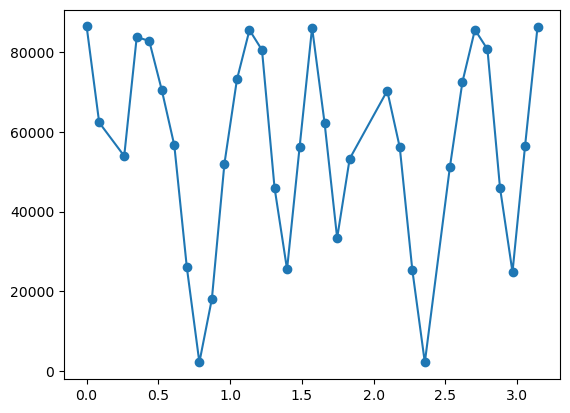

In [82]:
plt.plot(Cal_theta1550, Cal_Ir_1550, marker='o')

In [64]:
# Now bring in the actual sample data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_500_1.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_1550_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1550_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [134]:
reduced_filename = 'Reduced_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1550_Reduced\\"
lcenter = [258, 252]
rcenter = [257, 329]
maxradius = 15
cutoff = 70000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1550 = extracted_data[0]
Ir_1550 = extracted_data[1]

In [135]:
Il_1550 = np.delete(Il_1550, [0, 28, 36])
Ir_1550 = np.delete(Ir_1550, [0, 28, 36])
theta1550 = np.delete(theta, [0, 28, 36])

In [81]:
ultimate_polarimetry(Cal_theta1550, Cal_Il_1550, Cal_Ir_1550, theta1550, Il_1550, Ir_1550)

[ 0.02423795  0.02641557 -0.02260591  0.01447317  0.04167669  0.03098602] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.01581104  0.01553783 -0.03175005  0.00250845 -0.03039081 -0.04841212] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 1.         -0.03626973  0.00304751 -0.00083235]
 [ 0.03266842  0.87073561  0.00278292  0.00503066]
 [ 0.00112156  0.00263527  0.87608016  0.00555907]
 [ 0.00009729 -0.00306464  0.00090613  0.9628219 ]]  Left calibration
[[ 0.97781608 -0.0442135  -0.00555115  0.00238482]
 [-0.04188546  1.          0.00514915  0.00308747]
 [-0.00664614  0.00714098  0.98476986  0.00633875]
 [ 0.00202919 -0.00552816 -0.00061662  0.93754374]]  Right calibration
0.44155553863546626  This is the retardance found from the left spot
0.41221375500388335  This is the retardance found from the right spot


(array([[ 1.        , -0.00963009,  0.00333233,  0.00320265],
        [-0.00807769,  0.93885098, -0.05088837,  0.00794251],
        [-0.0075191 , -0.04600083, -0.9030635 , -0.21525261],
        [-0.0012959 ,  0.00605868,  0.22650945, -0.93332997]]),
 array([[ 0.92518427, -0.06665195,  0.01204302, -0.00255797],
        [-0.07989584,  1.        , -0.10035609,  0.00564011],
        [ 0.00579832, -0.08973893, -0.96859457, -0.21897927],
        [-0.01069341,  0.02217773,  0.22022035, -0.85169906]]),
 0.4268846468196748)

Retake the 1550 nm data, this time with 600 fps, 0.4 tint

In [83]:
# First reduce the calibration data
raw_image = 'DRRP_Cal_1550nm_Retaken_600_0.4_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_600_0.4.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Raw\\Cal_1550_Retaken_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1550_Retaken_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [89]:
reduced_filename = 'Reduced_DRRP_Cal_1550nm_Retaken_600_0.4_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1550_Retaken_Reduced\\"
lcenter = [259, 253]
rcenter = [259, 329]
maxradius = 13
cutoff = 20000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Retaken_Cal_Il_1550 = extracted_data[0]
Retaken_Cal_Ir_1550 = extracted_data[1]

In [90]:
Retaken_Cal_Il_1550 = np.delete(Retaken_Cal_Il_1550, [1, 5, 8, 11, 27, 35, 36])
Retaken_Cal_Ir_1550 = np.delete(Retaken_Cal_Ir_1550, [1, 5, 8, 11, 27, 35, 36])
Retaken_Cal_theta1550 = np.delete(theta, [1, 5, 8, 11, 27, 35, 36])

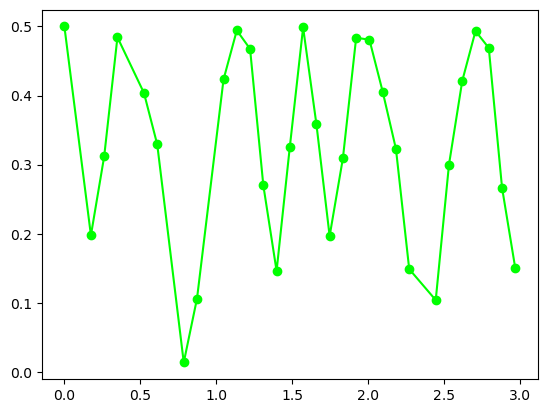

In [106]:
plt.plot(Retaken_Cal_theta1550, Retaken_Cal_Ir_1550/(2*np.max(Retaken_Cal_Ir_1550)), marker='o', color='lime')

In [88]:
# Now bring in the actual sample data
raw_image = 'DRRP_Uncoated_1550nm_Retaken_600_0.4_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_600_0.4.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_1550_Retaken_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1550_Retaken_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [97]:
reduced_filename = 'Reduced_DRRP_Uncoated_1550nm_Retaken_600_0.4_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1550_Retaken_Reduced\\"
lcenter = [259, 253]
rcenter = [258, 329]
maxradius = 15
cutoff = 27000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Retaken_Il_1550 = extracted_data[0]
Retaken_Ir_1550 = extracted_data[1]

In [98]:
Retaken_Il_1550 = np.delete(Retaken_Il_1550, [9])
Retaken_Ir_1550 = np.delete(Retaken_Ir_1550, [9])
Retaken_theta1550 = np.delete(theta, [9])

In [103]:
MCal1550 = calibrated_full_mueller_polarimetry(Retaken_Cal_theta1550, 0.04793312, 0.0511963, 0.06320084, -0.05946429, 0.02685385, 0.00487121, Retaken_Cal_Ir_1550)
print(MCal1550/MCal1550.max())
#0.06446347  0.06386449  0.08128197 -0.04244433  0.01607698  0.00148875
#0.04793312  0.0511963   0.06320084 -0.05946429  0.02685385  0.00487121
#  0.02423795  0.02641557 -0.02260591  0.01447317  0.04167669  0.03098602

[[ 1.          0.09729397 -0.17510235 -0.01431213]
 [ 0.02190064  0.72856069  0.60502772  0.01819452]
 [ 0.19912231 -0.74520166  0.72754955  0.03389466]
 [-0.00770799  0.04407727 -0.01330247  0.89696236]]


In [99]:
ultimate_polarimetry(Retaken_Cal_theta1550, Retaken_Cal_Il_1550, Retaken_Cal_Ir_1550, Retaken_theta1550, Retaken_Il_1550, Retaken_Ir_1550)

[ 0.02719807  0.02966114 -0.02054348  0.01491767  0.0605798   0.02357647] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.02499071  0.01719084 -0.02197625  0.0072084  -0.03740957 -0.05469126] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 1.         -0.02648768 -0.00124575 -0.00507288]
 [ 0.03762996  0.87418534  0.00059481 -0.00521085]
 [-0.00310985  0.00902584  0.87510089 -0.00188813]
 [ 0.0026208  -0.00439273  0.00523786  0.96505211]]  Left calibration
[[ 0.97375228 -0.03528102  0.00222058 -0.00269049]
 [-0.03148676  0.98331281 -0.00578157  0.01258955]
 [ 0.01197911 -0.023004    1.          0.00449735]
 [-0.00251253  0.00322008 -0.00926869  0.93347699]]  Right calibration
0.4357425442106064  This is the retardance found from the left spot
0.4041380713963858  This is the retardance found from the right spot


(array([[ 1.        , -0.01531891,  0.00443279,  0.00588609],
        [ 0.01009369,  0.89693604,  0.05534001,  0.0114217 ],
        [-0.00675267,  0.04546387, -0.86708465, -0.22856732],
        [ 0.0012524 , -0.02624543,  0.22459106, -0.91959754]]),
 array([[ 0.92142713, -0.0749442 , -0.01335636, -0.00349216],
        [-0.10222034,  1.        ,  0.05710031,  0.01017121],
        [-0.00665901,  0.04665129, -0.94688135, -0.23266658],
        [-0.00651155, -0.01027865,  0.22173411, -0.82402441]]),
 0.4199403078034961)

Now lets do 1600 nm, 300 fps, 3.3 tint

In [58]:
# First reduce the calibration data
raw_image = 'DRRP_Cal_1500nm300_3.3_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Raw\\Cal_1600_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1600_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [56]:
reduced_filename = 'Reduced_DRRP_Cal_1500nm300_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1600_Reduced\\"
lcenter = [258, 252]
rcenter = [258, 329]
maxradius = 9
cutoff = 12000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1600 = extracted_data[0]
#print(Cal_Il_1600)
Cal_Ir_1600 = extracted_data[1]
#print(Cal_Ir_1600)
#print('Bad indices: ' + str(extracted_data[2]))

In [57]:
Cal_Il_1600 = np.delete(Cal_Il_1600, [0, 7, 13, 14])
Cal_Ir_1600 = np.delete(Cal_Ir_1600, [0, 7, 13, 14])
Cal_theta1600 = np.delete(theta, [0, 7, 13, 14])

In [59]:
# Now bring in the actual sample data
raw_image = 'DRRP_Uncoated_1600nm_300_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_1600_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1600_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [60]:
reduced_filename = 'Reduced_DRRP_Uncoated_1600nm_300_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1600_Reduced\\"
lcenter = [258, 252]
rcenter = [257, 329]
maxradius = 9
cutoff = 15000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1600 = extracted_data[0]
#print(Realigned_Il_1500)
Ir_1600 = extracted_data[1]
#print(Realigned_Ir_1500)
#print('Bad indices: ' + str(extracted_data[2]))

In [61]:
Il_1600 = np.delete(Il_1600, [14, 32, 33, 34])
Ir_1600 = np.delete(Ir_1600, [14, 32, 33, 34])
theta1600 = np.delete(theta, [14, 32, 33, 34])

In [62]:
ultimate_polarimetry(Cal_theta1600, Cal_Il_1600, Cal_Ir_1600, theta1600, Il_1600, Ir_1600)

[ 0.03281     0.0383252   0.05020145 -0.07245235  0.02063271  0.00637496] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.04793312  0.0511963   0.06320084 -0.05946429  0.02685385  0.00487121] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 1.         -0.0065565  -0.00006938  0.00636881]
 [ 0.00783346  0.98445188  0.00224048  0.00594042]
 [-0.00147128  0.00398797  0.98266724 -0.00060557]
 [-0.00176522 -0.00073735  0.0039136   0.99744067]]  Left calibration
[[ 0.9981469  -0.00505288 -0.00000719  0.00587712]
 [-0.00329073  0.98315893  0.00421845  0.00287302]
 [-0.00657364  0.01050535  1.         -0.01247544]
 [ 0.00611732 -0.00647099 -0.01369449  0.98876495]]  Right calibration
0.47950195479571245  This is the retardance found from the left spot
0.46817994285382897  This is the retardance found from the right spot


(array([[ 1.        , -0.00509118, -0.00211906, -0.00496846],
        [-0.00016518,  0.98739646,  0.0205981 ,  0.11420561],
        [-0.00861057,  0.02537072, -0.99111006, -0.07208347],
        [ 0.00189128,  0.11450809,  0.07975542, -0.99171764]]),
 array([[ 1.        , -0.0084522 ,  0.00053631,  0.00250051],
        [ 0.00445315,  0.98528583,  0.06206105,  0.11876631],
        [ 0.00545279,  0.07660651, -0.97669765, -0.07288622],
        [-0.00273179,  0.11551411,  0.08307931, -0.98008022]]),
 0.4738409488247707)

Try 1620 nm at 300 fps, 3.3 tint

In [107]:
# First reduce the calibration data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Raw\\Cal_1620_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1620_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [32]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1620_Reduced\\"
lcenter = [258, 252]
rcenter = [258, 329]
maxradius = 11
cutoff = 20000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1620 = extracted_data[0]
Cal_Ir_1620 = extracted_data[1]

In [33]:
Cal_Il_1620 = np.delete(Cal_Il_1620, [39, 45])
Cal_Ir_1620 = np.delete(Cal_Ir_1620, [39, 45])
Cal_theta1620 = np.delete(longtheta, [39, 45])

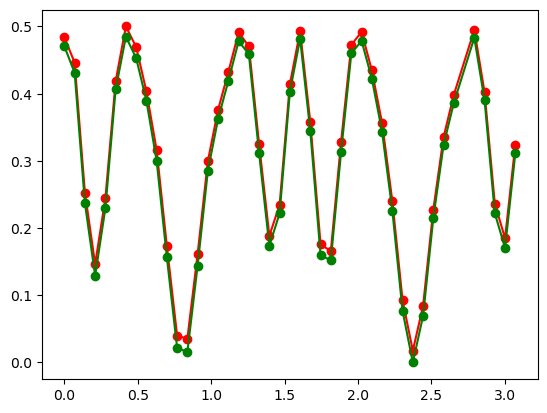

In [71]:
plt.plot(Cal_theta1620, Cal_Ir_1620/(2*np.max(Cal_Ir_1620)), marker='o', color='red')
plt.plot(Cal_theta1620, 0.50-Cal_Il_1620/(2*np.max(Cal_Il_1620)), marker='o', color='green')

In [117]:
# Now bring in the actual sample data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_1620_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1620_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [34]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1620_Reduced\\"
lcenter = [258, 252]
rcenter = [257, 329]
maxradius = 11
cutoff = 15000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1620 = extracted_data[0]
Ir_1620 = extracted_data[1]

In [35]:
Il_1620 = np.delete(Il_1620, [13, 39, 42, 45])
Ir_1620 = np.delete(Ir_1620, [13, 39, 42, 45])
theta1620 = np.delete(longtheta, [13, 39, 42, 45])

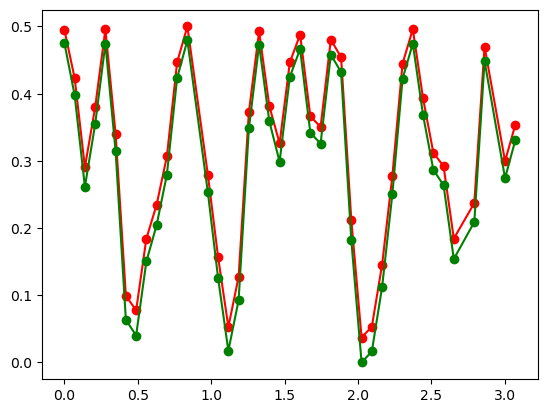

In [73]:
plt.plot(theta1620, Ir_1620/(2*np.max(Ir_1620)), marker='o', color='red')
plt.plot(theta1620, 0.50-Il_1620/(2*np.max(Il_1620)), marker='o', color='green')

In [124]:
MCal1620 = calibrated_full_mueller_polarimetry(Cal_theta1620, 0.12808216,  0.13603717,  0.13559918,  0.00576754,  0.00912039, -0.0078644, Cal_Il_1620, LPA_angle = np.pi/2)
print(MCal1620/MCal1620.max())

[[ 0.99958276  0.02692357  0.00964142  0.00250894]
 [-0.02642876  0.99837671 -0.00249164  0.01950488]
 [-0.00804959 -0.00190847  1.          0.00478757]
 [ 0.00195904 -0.00218469 -0.00235028  0.9431156 ]]


In [42]:
testing = calibrated_full_mueller_polarimetry(theta1620, 0.12808216,  0.13603717,  0.13559918,  0.00576754,  0.00912039, -0.0078644, Il_1620, LPA_angle = np.pi/2)
testing = testing/testing.max()
print(testing)
print(np.arccos(testing[3,3])/(2*np.pi))

[[ 1.          0.03665638  0.00875313 -0.00471549]
 [-0.0273569   0.9501568   0.33506246  0.04430789]
 [ 0.00116553  0.31100595 -0.91334737 -0.23037175]
 [-0.00029784 -0.05397884  0.22359006 -0.90243489]]
0.42911108911175544


In [47]:
normalized_intensity = Cal_Il_1620/(2*max(Cal_Il_1620))
angles = Cal_theta1620
initial_guess = [0.12808216,  0.13603717,  0.13559918,  0.00576754,  0.00912039, -0.0078644]
parameter_bounds = ([-np.pi, -np.pi, -np.pi, -np.pi, -np.pi/2, -np.pi/2], [np.pi, np.pi, np.pi, np.pi, np.pi/2, np.pi/2])
popt, pcov = curve_fit(vertical_calibration_function, angles, normalized_intensity, p0=initial_guess, bounds=parameter_bounds)
print(popt, "Parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer")
print(np.sqrt(np.diag(pcov)))

[0.13649185 0.14308891 0.14444258 0.01447388 0.08657529 0.06561915] Parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[54571.32325177 54571.32410291 54571.32335673 54571.32372445
     0.01313173     0.01330536]


In [48]:
testMCal1620 = calibrated_full_mueller_polarimetry(Cal_theta1620, 0.13649185, 0.14308891, 0.14444258, 0.01447388, 0.08657529, 0.06561915, Cal_Il_1620, LPA_angle = np.pi/2)
print(testMCal1620/testMCal1620.max())

[[ 1.         -0.03556069 -0.01175596  0.00096796]
 [ 0.03915976  0.86462998 -0.00447404  0.01798935]
 [ 0.01080233  0.00028678  0.86535685  0.00466328]
 [ 0.00186498 -0.00192726 -0.00252796  0.94969448]]


In [120]:
ultimate_polarimetry(Cal_theta1620, Cal_Il_1620, Cal_Ir_1620, theta1620, Il_1620, Ir_1620)

[ 0.07922918  0.08582623  0.0871799  -0.0427888   0.08657531  0.06561914] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.12808216  0.13603717  0.13559918  0.00576754  0.00912039 -0.0078644 ] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 1.         -0.03667114 -0.00761524  0.00096796]
 [ 0.04013768  0.8641641  -0.00433683  0.01840441]
 [ 0.00625657  0.00042397  0.86582272  0.00257699]
 [ 0.00186498 -0.00220351 -0.00229116  0.94969449]]  Left calibration
[[ 1.         -0.03634463 -0.00413885  0.00282323]
 [-0.03337235  0.99624335 -0.00561106  0.01802571]
 [-0.00943817  0.00341809  0.99836906  0.00291201]
 [ 0.00189895 -0.00113125 -0.00162435  0.93261432]]  Right calibration
0.43108339612137997  This is the retardance found from the left spot
0.426911005744086  This is the retardance found from the right spot


(array([[ 1.        , -0.02945025,  0.00886041, -0.00252761],
        [ 0.04088196,  0.86074117,  0.13354481,  0.02086349],
        [ 0.00182085,  0.11104325, -0.82870838, -0.21754301],
        [ 0.00037447, -0.03044479,  0.21207812, -0.90770442]]),
 array([[ 1.        , -0.04654797, -0.00188947,  0.00698881],
        [-0.03404107,  0.95568447,  0.33023985,  0.04219363],
        [-0.00327668,  0.31532756, -0.90699838, -0.23114076],
        [ 0.00187172, -0.05847663,  0.22174033, -0.89639332]]),
 0.42899720093273297)

Now take data for 1650 nm, 300 fps, 3.3 tint, 4 degree increments

In [16]:
# First reduce the calibration data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Raw\\Cal_1650_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1650_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [20]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1650_Reduced\\"
lcenter = [257, 252]
rcenter = [257, 328]
maxradius = 11
cutoff = 25000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1650 = extracted_data[0]
Cal_Ir_1650 = extracted_data[1]

In [21]:
Cal_Il_1650 = np.delete(Cal_Il_1650, [16, 41, 45])
Cal_Ir_1650 = np.delete(Cal_Ir_1650, [16, 41, 45])
Cal_theta1650 = np.delete(longtheta, [16, 41, 45])

In [22]:
# Now bring in the actual sample data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_300_3.3.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_1650_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1650_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [24]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1650_Reduced\\"
lcenter = [257, 252]
rcenter = [257, 329]
maxradius = 11
cutoff = 30000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1650 = extracted_data[0]
Ir_1650 = extracted_data[1]

In [25]:
Il_1650 = np.delete(Il_1650, [3, 38])
Ir_1650 = np.delete(Ir_1650, [3, 38])
theta1650 = np.delete(longtheta, [3, 38])

In [26]:
ultimate_polarimetry(Cal_theta1650, Cal_Il_1650, Cal_Ir_1650, theta1650, Il_1650, Ir_1650)

[ 0.0589598   0.08742055  0.05651467 -0.07809659  0.06410453  0.05297788] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.05931171  0.09285924  0.05919414 -0.07461792  0.00682929  0.0003144 ] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 1.         -0.02398084 -0.01430732 -0.0067902 ]
 [ 0.02119301  0.91468488  0.00682394  0.01566713]
 [ 0.02538854 -0.01633432  0.983279    0.02598947]
 [ 0.00630778 -0.00719955  0.02192888  0.98419898]]  Left calibration
[[ 0.9924737  -0.02429095 -0.01928987 -0.00837728]
 [-0.02546121  1.          0.00354706  0.01975046]
 [-0.01533024 -0.00300736  0.93937133 -0.02429466]
 [-0.00635476  0.00509637 -0.01870708  0.94153102]]  Right calibration
0.44321978298391135  This is the retardance found from the left spot
0.4373459229414382  This is the retardance found from the right spot


(array([[ 1.        , -0.00869558,  0.00832509, -0.01084191],
        [ 0.02580225,  0.91441156,  0.10818983, -0.01335089],
        [-0.00364039,  0.08148735, -0.87941162, -0.17596345],
        [-0.0019444 , -0.03766305,  0.17154859, -0.93703306]]),
 array([[ 0.99799057, -0.03408228, -0.00123517,  0.01408301],
        [-0.02773228,  1.        ,  0.12262859, -0.01171245],
        [-0.00674751,  0.10749749, -0.97550004, -0.18198139],
        [ 0.00222383, -0.04772506,  0.17333757, -0.92350863]]),
 0.4402828529626748)

1750 nm, 600 fps, 0.4 tint

In [43]:
# First reduce the calibration data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_600_0.4.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Raw\\Cal_1750_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1750_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [44]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1750_Reduced\\"
lcenter = [257, 252]
rcenter = [257, 328]
maxradius = 13
cutoff = 40000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1750 = extracted_data[0]
Cal_Ir_1750 = extracted_data[1]

In [45]:
Cal_Il_1750 = np.delete(Cal_Il_1750, [6, 7, 16, 24, 30, 32])
Cal_Ir_1750 = np.delete(Cal_Ir_1750, [6, 7, 16, 24, 30, 32])
Cal_theta1750 = np.delete(longtheta, [6, 7, 16, 24, 30, 32])

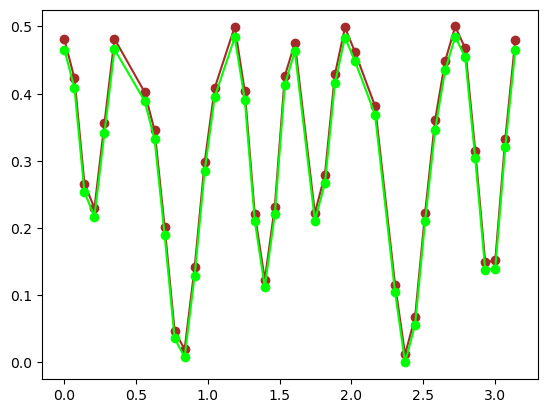

In [62]:
plt.plot(Cal_theta1750, Cal_Ir_1750/(2*np.max(Cal_Ir_1750)), marker='o', color='brown')
plt.plot(Cal_theta1750, 0.5-Cal_Il_1750/(2*np.max(Cal_Il_1750)), marker='o', color='lime')
#plt.plot(longtheta, 0.25, color='red', linestyle='--')

In [49]:
# Now bring in the actual sample data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_600_0.4.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_1750_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1750_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [50]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1750_Reduced\\"
lcenter = [257, 252]
rcenter = [257, 329]
maxradius = 11
cutoff = 50000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1750 = extracted_data[0]
Ir_1750 = extracted_data[1]

In [51]:
Il_1750 = np.delete(Il_1750, [5, 10, 28, 45])
Ir_1750 = np.delete(Ir_1750, [5, 10, 28, 45])
theta1750 = np.delete(longtheta, [5, 10, 28, 45])

In [52]:
ultimate_polarimetry(Cal_theta1750, Cal_Il_1750, Cal_Ir_1750, theta1750, Il_1750, Ir_1750)

[ 0.02232869  0.09093786 -0.06934237  0.00397408  0.03019265  0.00003808] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.03931005  0.09874209 -0.05419691  0.01551712 -0.03919446 -0.05855201] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 1.         -0.03067695  0.00419712 -0.00030801]
 [ 0.03608853  0.86694037  0.003394   -0.00046858]
 [ 0.00935616 -0.01158948  0.86756707  0.00040578]
 [-0.00041003 -0.00151812  0.00324016  0.96256699]]  Left calibration
[[ 1.         -0.03123619 -0.01663835  0.00051302]
 [-0.03304314  0.99634602  0.01364279  0.00058027]
 [ 0.00034278 -0.0067363   0.997498   -0.00245135]
 [ 0.00052288 -0.0030995   0.00018251  0.96549212]]  Right calibration
0.44991629723438986  This is the retardance found from the left spot
0.42714640141455473  This is the retardance found from the right spot


(array([[ 1.        ,  0.0325501 , -0.02319072, -0.00665024],
        [-0.01801727,  0.91911002, -0.36000271, -0.04518527],
        [ 0.00670556, -0.36717439, -0.9094964 , -0.12244837],
        [ 0.00338908,  0.00681391,  0.13001887, -0.95089387]]),
 array([[ 0.94624941, -0.08695446,  0.04537456,  0.01054385],
        [-0.07762642,  1.        , -0.33169414, -0.04391414],
        [ 0.02857985, -0.3256807 , -0.98568767, -0.12597343],
        [ 0.0020202 ,  0.00373358,  0.12845853, -0.89704794]]),
 0.4385313493244723)

1900 nm, 600 fps, 0.4 tint

In [74]:
# First reduce the calibration data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_600_0.4.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Raw\\Cal_1900_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1900_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [91]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_1900_Reduced\\"
lcenter = [257, 252]
rcenter = [257, 328]
maxradius = 13
cutoff = 30000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1900 = extracted_data[0]
Cal_Ir_1900 = extracted_data[1]

In [92]:
Cal_Il_1900 = np.delete(Cal_Il_1900, [3, 5, 8, 13, 31, 37, 43, 44, 45])
Cal_Ir_1900 = np.delete(Cal_Ir_1900, [3, 5, 8, 13, 31, 37, 43, 44, 45])
Cal_theta1900 = np.delete(longtheta, [3, 5, 8, 13, 31, 37, 43, 44, 45])

In [93]:
normalized_intensity = Cal_Il_1900/(2*max(Cal_Il_1900))
angles = Cal_theta1900
initial_guess = [0, 0, 0, 0, 0, 0]
parameter_bounds = ([-np.pi, -np.pi, -np.pi, -np.pi, -np.pi/2, -np.pi/2], [np.pi, np.pi, np.pi, np.pi, np.pi/2, np.pi/2])
popt, pcov = curve_fit(vertical_calibration_function, angles, normalized_intensity, p0=initial_guess, bounds=parameter_bounds)
print(popt, "Parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer")
print(np.sqrt(np.diag(pcov)))

[ 0.04566178  0.09059937 -0.07473568  0.08876498  0.03903311  0.04470612] Parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[48896.65165729 48896.65165859 48896.6518843  48896.65167683
     0.00714677     0.00638898]


In [94]:
MCal1900 = calibrated_full_mueller_polarimetry(Cal_theta1900, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], Cal_Il_1900, LPA_angle=np.pi/2)
print(MCal1900/MCal1900.max())

[[ 1.         -0.0141698   0.0064848   0.00496198]
 [ 0.01137123  0.95162864  0.00382985  0.00056869]
 [ 0.00225514 -0.00557241  0.97512134  0.00620306]
 [ 0.00537443 -0.00816793 -0.01055889  0.99780144]]


In [85]:
# Now bring in the actual sample data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_600_0.4.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_1900_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1900_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [97]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_1900_Reduced\\"
lcenter = [257, 252]
rcenter = [257, 329]
maxradius = 13
cutoff = 40000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1900 = extracted_data[0]
Ir_1900 = extracted_data[1]

In [98]:
Il_1900 = np.delete(Il_1900, [3, 34])
Ir_1900 = np.delete(Ir_1900, [3, 34])
theta1900 = np.delete(longtheta, [3, 34])

In [99]:
ultimate_polarimetry(Cal_theta1900, Cal_Il_1900, Cal_Ir_1900, theta1900, Il_1900, Ir_1900)

[ 0.04566178  0.09059937 -0.07473568  0.08876498  0.03903311  0.04470612] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.04728016  0.09744958 -0.07316673  0.09406128  0.01118787  0.01159933] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 1.         -0.0141698   0.0064848   0.00496198]
 [ 0.01137123  0.95162864  0.00382985  0.00056869]
 [ 0.00225514 -0.00557241  0.97512134  0.00620306]
 [ 0.00537443 -0.00816793 -0.01055889  0.99780144]]  Left calibration
[[ 1.         -0.01281226 -0.0053773   0.00484681]
 [-0.01578823  0.99831347  0.00132835 -0.00436733]
 [-0.00463259  0.0029161   0.99360583  0.00112065]
 [ 0.00424923 -0.00513617 -0.00349006  0.97929239]]  Right calibration
0.4517500539214723  This is the retardance found from the left spot
0.4508742809951142  This is the retardance found from the right spot


(array([[ 1.        , -0.01229371,  0.01202015,  0.00010779],
        [ 0.00313504,  0.94817524, -0.12806895, -0.03332208],
        [-0.01286842, -0.11850318, -0.92133179, -0.17531327],
        [ 0.00163032, -0.01446265,  0.17971463, -0.95439688]]),
 array([[ 0.98473492, -0.01018969,  0.0061089 ,  0.0035337 ],
        [-0.01271529,  1.        , -0.11838893, -0.03805587],
        [ 0.00124541, -0.11387982, -0.98864187, -0.18570062],
        [-0.0015796 , -0.01168892,  0.19271506, -0.95273967]]),
 0.4513121674582933)

2000 nm, 600 fps, 0.4 tint

In [100]:
# First reduce the calibration data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_600_0.4.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Raw\\Cal_2000_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_2000_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [101]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Calibrations\\Calibrations_Reduced\\Cal_2000_Reduced\\"
lcenter = [257, 252]
rcenter = [257, 329]
maxradius = 13
cutoff = 30000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_2000 = extracted_data[0]
Cal_Ir_2000 = extracted_data[1]

In [102]:
Cal_Il_2000 = np.delete(Cal_Il_2000, [12, 14, 16, 26, 44])
Cal_Ir_2000 = np.delete(Cal_Ir_2000, [12, 14, 16, 26, 44])
Cal_theta2000 = np.delete(longtheta, [12, 14, 16, 26, 44])

In [103]:
# Now bring in the actual sample data
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Darks\\Dark_600_0.4.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Raw\\Uncoated_2000_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_2000_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [105]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\DRRP_HWP_Characterization\\Uncoated_JHK\\Uncoated_Reduced\\Uncoated_2000_Reduced\\"
lcenter = [257, 252]
rcenter = [257, 329]
maxradius = 13
cutoff = 50000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_2000 = extracted_data[0]
Ir_2000 = extracted_data[1]

In [106]:
Il_2000 = np.delete(Il_2000, [6, 10, 17, 20, 22, 26, 30, 33, 38, 39])
Ir_2000 = np.delete(Ir_2000, [6, 10, 17, 20, 22, 26, 30, 33, 38, 39])
theta2000 = np.delete(longtheta, [6, 10, 17, 20, 22, 26, 30, 33, 38, 39])

In [112]:
normalized_intensity = Cal_Ir_2000/(2*max(Cal_Ir_2000))
angles = Cal_theta2000
initial_guess = [0.03, 0.08, -0.05, 0.04, 0, 0]
parameter_bounds = ([-np.pi, -np.pi, -np.pi, -np.pi, -np.pi/2, -np.pi/2], [np.pi, np.pi, np.pi, np.pi, np.pi/2, np.pi/2])
popt, pcov = curve_fit(calibration_function, angles, normalized_intensity, p0=initial_guess, bounds=parameter_bounds)
print(popt, "Parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer")
print(np.sqrt(np.diag(pcov)))

[ 0.03175273  0.09843691 -0.06358607  0.04153264 -0.0225697  -0.02790292] Parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[456929.96057068 456929.95655314 456929.96072424 456929.95591628
      0.05686201      0.05161946]


In [113]:
MCal2000 = calibrated_full_mueller_polarimetry(Cal_theta2000, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], Cal_Ir_2000, LPA_angle=0)
print(MCal2000/MCal2000.max())

[[ 1.         -0.0054701  -0.04106319 -0.00516095]
 [ 0.02050692  0.8023802   0.03274039  0.02541939]
 [-0.02414656  0.09054999  0.96333364 -0.00491561]
 [ 0.00940781 -0.03742378  0.00369027  0.96396044]]


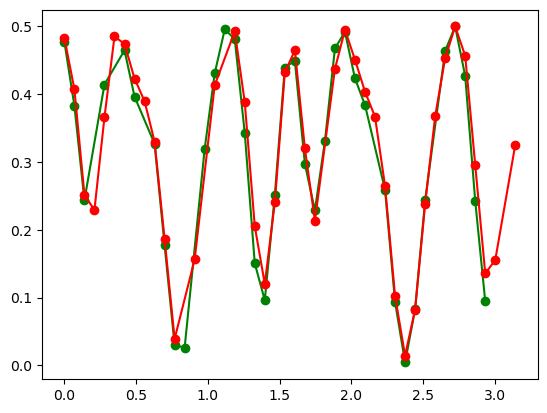

In [114]:
plt.plot(Cal_theta1900, Cal_Ir_1900/(2*np.max(Cal_Ir_1900)), marker='o', color='g')
plt.plot(Cal_theta2000, Cal_Ir_2000/(2*np.max(Cal_Ir_2000)), marker='o', color='r')

In [107]:
ultimate_polarimetry(Cal_theta2000, Cal_Il_2000, Cal_Ir_2000, theta2000, Il_2000, Ir_2000)

[ 0.03327186  0.08695288 -0.05253712  0.03879363  0.04151169  0.04166328] Left parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[ 0.02667171  0.09335436 -0.06866726  0.03645016 -0.02256962 -0.02790252] Right parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer
[[ 1.         -0.02413744 -0.00444331  0.00482684]
 [ 0.02716368  0.90303433 -0.01136158  0.00231062]
 [ 0.01112855 -0.01094587  0.87612326  0.00995099]
 [-0.00133174  0.00512635  0.00068025  0.9681234 ]]  Left calibration
[[ 1.         -0.00588685 -0.04100526 -0.00516091]
 [ 0.02026045  0.80364948  0.03436529  0.02536811]
 [-0.02435407  0.09217115  0.96206343 -0.00517374]
 [ 0.0094078  -0.03738432  0.00407039  0.96396038]]  Right calibration
0.4385216555200033  This is the retardance found from the left spot
0.4307596509924253  This is the retardance found from the right spot


(array([[ 1.        , -0.00639084, -0.00101198,  0.00101045],
        [-0.02168721,  0.91774408, -0.17759795, -0.00438373],
        [-0.00962714, -0.18305279, -0.8767198 , -0.19220876],
        [-0.00651985,  0.01950626,  0.20479654, -0.92631702]]),
 array([[ 0.96199655, -0.04076231,  0.05504172,  0.01440867],
        [-0.06876589,  1.        , -0.28602049, -0.01815646],
        [ 0.0241032 , -0.26256614, -0.98773153, -0.19674009],
        [-0.01246415,  0.03159306,  0.20170919, -0.90684899]]),
 0.43464065325621426)

Now lets make an overall plot showing the retardance at each wavelength

In [136]:
wavelength_bins = np.array([1400, 1500, 1550, 1600, 1620, 1650, 1750, 1900, 2000])
retardances = np.array([0.480, 0.472, 0.427, 0.474, 0.429, 0.440, 0.439, 0.451, 0.435])